In [1]:
import os
import math
import numpy as np
from fractions import Fraction
from collections import defaultdict
from typing import Dict, List, Tuple, Set
from tqdm import tqdm
import multiprocessing as mp
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.cm import ScalarMappable
from matplotlib.ticker import FixedLocator, FuncFormatter
from haversine import haversine, Unit
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as patches

In [2]:
# Astronomy-related constants

TE = 24 * 3600  # One Earth sidereal day in seconds

RE = 6371e3  # Mean radius of Earth in meters

u = 3.986e14  # Standard gravitational parameter (μ = GM) in m^3/s^2

K = RE / pow(u, 1/3) * pow(2 * np.pi, 2/3)  

eps = 25 * np.pi / 180  # Maximum elevation angle for ground access, in radians (25°)

In [3]:
# === Utility Functions for LEO Satellite Coverage Modeling ===

def satellite_period(h):
    """
    Compute orbital period based on altitude h (in meters).
    
    Args:
        h (float): Satellite altitude in meters
    
    Returns:
        float: Orbital period in seconds
    """
    a = RE + h
    T = float(2 * np.pi * pow(a**3 / u, 0.5))  # Kepler's Third Law
    return T


def approximate_ratio(a, b, precision=1e-3):
    """
    Approximate the simplest integer ratio between two values.
    
    Args:
        a, b (float): Input values
        precision (float): Allowed approximation error
    
    Returns:
        (int, int): Simplified numerator and denominator
    """
    if b == 0:
        raise ValueError("Denominator cannot be zero")
    ratio = Fraction(a, b).limit_denominator(int(1 / precision))
    return ratio.numerator, ratio.denominator


def coverage_eta(T):
    """
    Compute half-angle ground coverage (in radians) from orbital period.
    
    Args:
        T (float): Orbital period in seconds
    
    Returns:
        float: Coverage angle in radians
    """
    eta = math.acos(K * math.cos(eps) / pow(T, 2 / 3)) - eps
    return eta


def alpha_gamma_to_lambda_phi(alpha, gamma, alpha0, inc):
    """
    Convert satellite-centric coordinates to Earth-centric lon/lat.
    
    Args:
        alpha (float): In-track satellite angle (rad)
        gamma (float): Along-track angle (rad)
        alpha0 (float): Reference phase angle (unused here)
        inc (float): Orbital inclination (rad)
    
    Returns:
        (float, float): (longitude, latitude) in radians
    """
    phi = math.asin(math.sin(inc) * math.sin(gamma))
    temp = math.atan2(math.cos(inc) * math.sin(gamma), math.cos(gamma))
    lamb = (temp + alpha) % (2 * math.pi)
    if lamb > math.pi:
        lamb -= 2 * math.pi
    return lamb, phi


def get_allfile(path):
    """
    List all non-checkpoint files under a directory.
    
    Args:
        path (str): Directory path
    
    Returns:
        list[str]: List of full file paths
    """
    all_file = []
    for f in os.listdir(path):
        f_name = os.path.join(path, f)
        if "ipynb_checkpoints" not in f_name:
            all_file.append(f_name)
    return all_file


def calculate_cell_area():
    """
    Compute surface area of each demand grid cell.
    
    Returns:
        list[float]: Area (in m^2) for each demand cell
    """
    S_set = []
    for demand in demand_list:
        p_cell = demand['lat_lon'][0]  # Latitude (radians)
        h = RE * np.radians(cell_size)  # Cell height in meters

        # Compute arc lengths on both sides of the cell
        L1 = RE * np.sin(np.pi / 2 - abs(p_cell)) * np.radians(cell_size)
        tmp = abs(p_cell - np.radians(cell_size))
        L2 = RE * np.sin(np.pi / 2 - min(tmp, np.pi / 2)) * np.radians(cell_size)

        # Adjust near-pole case (e.g. South Pole)
        if tmp > np.pi / 2:
            h = RE * abs(p_cell + np.pi / 2)

        S = 0.5 * h * (L1 + L2)  # Trapezoidal area
        S_set.append(S)
    return S_set


def is_cover(l_sat, p_sat, l_cell, p_cell, eta):
    """
    Determine if satellite at (l_sat, p_sat) covers a ground cell at (l_cell, p_cell).
    
    Args:
        l_sat, p_sat (float): Satellite lon/lat (radians)
        l_cell, p_cell (float): Cell lon/lat (radians)
        eta (float): Coverage half-angle (radians)
    
    Returns:
        bool: True if covered
    """
    # If potential overlap crosses poles or dateline, use distance
    if (p_sat - 2 * eta < -np.pi / 2 or p_sat + 2 * eta > np.pi / 2 or
        l_sat - 2 * eta < -np.pi or l_sat + 2 * eta > np.pi):
        d = haversine((np.degrees(p_sat), np.degrees(l_sat)),
                      (np.degrees(p_cell), np.degrees(l_cell)), unit=Unit.METERS)
        return d <= eta * RE
    else:
        # Bounding box pre-check
        if (p_sat - 2 * eta) <= p_cell <= (p_sat + 2 * eta) and \
           (l_sat - 2 * eta) <= l_cell <= (l_sat + 2 * eta):
            d = haversine((np.degrees(p_sat), np.degrees(l_sat)),
                          (np.degrees(p_cell), np.degrees(l_cell)), unit=Unit.METERS)
            return d <= eta * RE
    return False


def cal_supply_all_cell(sat_pos):
    """
    Compute satellite-to-cell capacity vector for a given satellite position.
    
    Args:
        sat_pos (tuple): Satellite (lon, lat) in radians
    
    Returns:
        [list[float], tuple]: Capacity vector and satellite position
    """
    l_sat, p_sat = sat_pos
    r_set = []

    T = satellite_period(h * 1e3)        # Orbital period at given altitude
    eta = coverage_eta(T)                # Coverage angle

    for idx, demand in enumerate(demand_list):
        l_cell = demand['lat_lon'][1]
        p_cell = demand['lat_lon'][0]
        if is_cover(l_sat, p_sat, l_cell, p_cell, eta):
            S = S_set[idx]
            r_set.append([idx, S, demand['density']])
        else:
            r_set.append([idx, 0, 0])

    S_sum = np.sum([item[1] for item in r_set])
    if S_sum != 0:
        r_set = [item[1] / S_sum * user_per_sat for item in r_set]
    else:
        r_set = [0] * len(demand_list)

    return [r_set, sat_pos]


In [4]:
# === Define Custom Colormap for Visualization ===

# Hex color string from light to dark
color_str = '#ffffff,#b4d9cc,#89c0b6,#63a6a0,#448c8a,#287274,#0d585f'
cmap_colors = color_str.split(',')

# Convert hex color strings to RGB tuples
color_list = [plt.cm.colors.hex2color(color) for color in cmap_colors]

data_max = 10  # Maximum value for color scaling

# Generate evenly spaced boundaries based on number of colors
color_bounds = np.linspace(0, data_max, len(cmap_colors))

# Normalize boundaries to [0, 1]
normalized_bounds = color_bounds / color_bounds[-1]

# Create a list of (position, color) for segmented colormap
colors = list(zip(normalized_bounds, color_list))

# Build a custom colormap and normalization object
cmap = LinearSegmentedColormap.from_list('custom_map', colors, N=256)
norm = Normalize(vmin=0, vmax=data_max)


In [5]:
demand_list=np.load("../../Dataset/Demand//starlink_supply_2025_01_01_99449.npy",allow_pickle=True)
for idx in range(len(demand_list)):
    demand_list[idx]['lat_lon'][0]=np.radians(demand_list[idx]['lat_lon'][0])
    demand_list[idx]['lat_lon'][1]=np.radians(demand_list[idx]['lat_lon'][1])
cell_size=4
user_per_sat = 960
S_set=calculate_cell_area()  

# Figure14a

In [6]:
data_file="data/TinyLEO_for_starlink_demand.npy"
supply_data=np.load(data_file,allow_pickle=True)
h=573

In [7]:
# === Aggregate All Unique Satellite Positions ===

full_cover_params = set()
for data in tqdm(supply_data):
    sat_location = data[2]  # List of [lon, lat] pairs
    full_cover_params.update(tuple(sat_pair) for sat_pair in sat_location)

# Convert set to list for processing
full_cover_params = list(full_cover_params)

# === Compute Per-Satellite Coverage in Parallel ===

with mp.Pool(processes=100) as pool:
    full_cover_beam = list(tqdm(
        pool.imap(cal_supply_all_cell, full_cover_params),
        total=len(full_cover_params),
        mininterval=5
    ))
    pool.close()
    pool.join()

# === Build Coverage Dictionary ===

full_cover_sat = {}
for cover, sat_pair in full_cover_beam:
    key = f"{sat_pair[0]}_{sat_pair[1]}"  # Use lon_lat key string
    full_cover_sat[key] = cover

print("Total unique satellites:", len(full_cover_sat))

# === Accumulate Total Ground Coverage from All Satellites ===

plt_data = []
sat_map = []
time_shift = 0  # Time step index for visualization

for data in supply_data:
    param, random_numbers, sat_location, sat_num = data
    sat_pair = sat_location[time_shift]
    key = f"{sat_pair[0]}_{sat_pair[1]}"
    
    # Accumulate weighted coverage
    if len(plt_data) == 0:
        plt_data = np.array(full_cover_sat[key]) * sat_num
    else:
        plt_data += np.array(full_cover_sat[key]) * sat_num

    # Store satellite location for plotting
    sat_map.append(sat_pair)

100%|██████████| 151441/151441 [03:39<00:00, 690.59it/s]


Total unique satellites: 151441


In [8]:
print(np.min(plt_data),np.max(plt_data))
norm = Normalize(vmin=np.min(0), vmax=np.max(plt_data))
colormap = plt.cm.Blues
sm = ScalarMappable(norm=norm, cmap=colormap)

0.0 1053.1113060804037


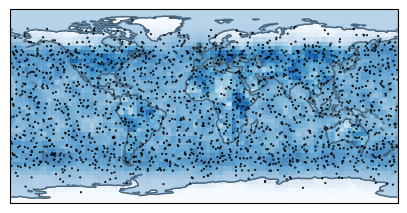

In [9]:
# --- Initialize the map with Cartopy ---
fig, ax = plt.subplots(figsize=(5, 5), subplot_kw={'projection': ccrs.PlateCarree()})

# Add coastlines and global extent
ax.coastlines()
ax.set_global()

# Add ocean background
ocean_feature = cfeature.NaturalEarthFeature(
    'physical', 'ocean', '110m',
    edgecolor='face',
    facecolor='#7BAED5',
    alpha=0.5
)
ax.add_feature(ocean_feature)

# --- Plot ground coverage as colored grid cells ---
for cid, value in enumerate(plt_data):
    demand = demand_list[cid]
    x = np.degrees(demand['lat_lon'][1])  # Longitude in degrees
    y = np.degrees(demand['lat_lon'][0])  # Latitude in degrees
    color = sm.to_rgba(value)             # Map value to color
    rect = patches.Rectangle(
        (x, y - 4), 4, 4,                 # Lower-left corner, width, height (in degrees)
        color=color, alpha=0.9,
        transform=ccrs.PlateCarree()
    )
    ax.add_patch(rect)

# --- Plot satellite locations as small black circles ---
for sat in sat_map:
    plt.scatter(
        np.degrees(sat[0]), np.degrees(sat[1]),
        s=0.3, c='none', marker='o',
        edgecolors="black", zorder=3,
        transform=ccrs.PlateCarree()
    )

# Set map extent and save the figure
plt.xlim(-180, 180)
plt.ylim(-90, 90)
plt.savefig("figure14a.pdf", bbox_inches="tight")
plt.savefig("figure14a.png", bbox_inches="tight")

In [10]:
supply_demand_ratio=[]
for idx,demand in enumerate(demand_list):
    if demand['density']!=0:
        supply_demand_ratio.append(plt_data[idx]/demand['density'])
print(np.mean(supply_demand_ratio))
np.save("../figure15/data/supply_demand_ratio_official.npy",supply_demand_ratio)

375.8320275716796


# Figure14b

In [11]:
data_file="data/TinyLEO_for_backbone_network.npy"
supply_data=np.load(data_file,allow_pickle=True)
h=573
T=satellite_period(h*1e3)
p,q=approximate_ratio(int(T), TE,precision=1e-3)
eta=coverage_eta(T)
step=2*eta

In [12]:
# === Aggregate All Unique Satellite Positions ===

full_cover_params = set()
for data in tqdm(supply_data):
    sat_location = data[2]  # List of [lon, lat] pairs
    full_cover_params.update(tuple(sat_pair) for sat_pair in sat_location)

# Convert set to list for processing
full_cover_params = list(full_cover_params)

# === Compute Per-Satellite Coverage in Parallel ===

with mp.Pool(processes=100) as pool:
    full_cover_beam = list(tqdm(
        pool.imap(cal_supply_all_cell, full_cover_params),
        total=len(full_cover_params),
        mininterval=5
    ))
    pool.close()
    pool.join()

# === Build Coverage Dictionary ===

full_cover_sat = {}
for cover, sat_pair in full_cover_beam:
    key = f"{sat_pair[0]}_{sat_pair[1]}"  # Use lon_lat key string
    full_cover_sat[key] = cover

print("Total unique satellites:", len(full_cover_sat))

# === Accumulate Total Ground Coverage from All Satellites ===

plt_data = []
sat_map = []
time_shift = 0  # Time step index for visualization

for data in supply_data:
    param, random_numbers, sat_location, sat_num = data
    sat_pair = sat_location[time_shift]
    key = f"{sat_pair[0]}_{sat_pair[1]}"
    
    # Accumulate weighted coverage
    if len(plt_data) == 0:
        plt_data = np.array(full_cover_sat[key]) * sat_num
    else:
        plt_data += np.array(full_cover_sat[key]) * sat_num

    # Store satellite location for plotting
    sat_map.append(sat_pair)


100%|██████████| 12313/12313 [00:14<00:00, 838.34it/s]


Total unique satellites: 12313


In [13]:
print(np.min(plt_data),np.max(plt_data))
norm = Normalize(vmin=np.min(0), vmax=np.max(plt_data))
colormap = plt.cm.Blues
sm = ScalarMappable(norm=norm, cmap=colormap)

0.0 2328.311206654784


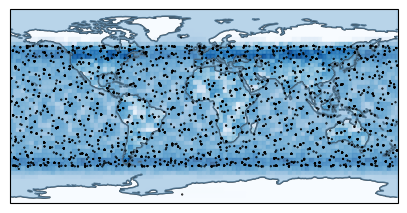

In [16]:
# --- Initialize the map with Cartopy ---
fig, ax = plt.subplots(figsize=(5, 5), subplot_kw={'projection': ccrs.PlateCarree()})

# Add coastlines and global extent
ax.coastlines()
ax.set_global()

# Add ocean background
ocean_feature = cfeature.NaturalEarthFeature(
    'physical', 'ocean', '110m',
    edgecolor='face',
    facecolor='#7BAED5',
    alpha=0.5
)
ax.add_feature(ocean_feature)

# --- Plot ground coverage as colored grid cells ---
for cid, value in enumerate(plt_data):
    demand = demand_list[cid]
    x = np.degrees(demand['lat_lon'][1])  # Longitude in degrees
    y = np.degrees(demand['lat_lon'][0])  # Latitude in degrees
    color = sm.to_rgba(value)             # Map value to color
    rect = patches.Rectangle(
        (x, y - 4), 4, 4,                 # Lower-left corner, width, height (in degrees)
        color=color, alpha=0.9,
        transform=ccrs.PlateCarree()
    )
    ax.add_patch(rect)

# --- Plot satellite locations as small black circles ---
for sat in sat_map:
    plt.scatter(
        np.degrees(sat[0]), np.degrees(sat[1]),
        s=0.3, c='none', marker='o',
        edgecolors="black", zorder=3,
        transform=ccrs.PlateCarree()
    )

# Set map extent and save the figure
plt.xlim(-180, 180)
plt.ylim(-90, 90)
plt.savefig("figure14b.pdf", bbox_inches="tight")
plt.savefig("figure14b.png", bbox_inches="tight")

In [17]:
supply_demand_ratio=[]
for idx,demand in enumerate(demand_list):
    if demand['density']!=0:
        supply_demand_ratio.append(plt_data[idx]/demand['density'])
print(np.mean(supply_demand_ratio))
np.save("../figure15/data/supply_demand_ratio_official.npy",supply_demand_ratio)

744.7615424372538
